In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import numpy as np
from gridworld import standard_grid, negative_grid
from iterative_policy_evaluation_probabilistic import print_values, print_policy
import pandas as pd

In [2]:
GAMMA = 0.9

# MC Policy Eval

In [3]:
# NOTE: this is only policy evaluation, not optimization

def play_game(grid, policy, max_steps=20):
  # returns a list of states and corresponding returns

  # reset game to start at a random position
  # we need to do this, because given our current deterministic policy
  # we would never end up at certain states, but we still want to measure their value
  start_states = list(grid.actions.keys())
  start_idx = np.random.choice(len(start_states))
  grid.set_state(start_states[start_idx])

  s = grid.current_state()

  # keep track of all states and rewards encountered
  states = [s]
  rewards = [0]

  steps = 0
  while not grid.game_over():
    a = policy[s]
    r = grid.move(a)
    next_s = grid.current_state()

    # update states and rewards lists
    states.append(next_s)
    rewards.append(r)

    steps += 1
    if steps >= max_steps:
      break

    # update state
    # note: there is no need to store the final terminal state
    s = next_s

  # we want to return:
  # states  = [s(0), s(1), ..., S(T)]
  # rewards = [R(0), R(1), ..., R(T)]

  return states, rewards

In [4]:
# use the standard grid again (0 for every step) so that we can compare
# to iterative policy evaluation
grid = standard_grid()

# print rewards
print("rewards:")
print_values(grid.rewards, grid)

# state -> action
policy = {
    (2, 0): 'U',
    (1, 0): 'U',
    (0, 0): 'R',
    (0, 1): 'R',
    (0, 2): 'R',
    (1, 2): 'R',
    (2, 1): 'R',
    (2, 2): 'R',
    (2, 3): 'U',
}


rewards:
---------------------------
 0.00| 0.00| 0.00| 1.00|
---------------------------
 0.00| 0.00| 0.00|-1.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|


In [5]:
# initialize V(s) and returns
V = {}
returns = {} # dictionary of state -> list of returns we've received
states = grid.all_states()
for s in states:
    if s in grid.actions:
        returns[s] = []
    else:
        # terminal state or state we can't otherwise get to
        V[s] = 0

# repeat
for _ in range(100):
    # generate an episode using pi
    states, rewards = play_game(grid, policy)
    G = 0
    T = len(states)
    for t in range(T - 2, -1, -1):
        s = states[t]
        r = rewards[t+1]
        G = r + GAMMA * G # update return

        # we'll use first-visit Monte Carlo
        if s not in states[:t]:
            returns[s].append(G)
            V[s] = np.mean(returns[s])

print("values:")
print_values(V, grid)
print("policy:")
print_policy(policy, grid)

values:
---------------------------
 0.81| 0.90| 1.00| 0.00|
---------------------------
 0.73| 0.00|-1.00| 0.00|
---------------------------
 0.66|-0.81|-0.90|-1.00|
policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  R  |     |
---------------------------
  U  |  R  |  R  |  U  |


# Policy Iteration with Exploring Starts

In [8]:
import matplotlib.pyplot as plt
from gridworld import standard_grid, negative_grid

In [9]:
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

In [10]:
# NOTE: this script implements the Monte Carlo Exploring-Starts method
#       for finding the optimal policy


def play_game(grid, policy, max_steps=20):
  # reset game to start at a random position
  # we need to do this if we have a deterministic policy
  # we would never end up at certain states, but we still want to measure their value
  # this is called the "exploring starts" method
  start_states = list(grid.actions.keys())
  start_idx = np.random.choice(len(start_states))
  grid.set_state(start_states[start_idx])

  s = grid.current_state()
  a = np.random.choice(ALL_POSSIBLE_ACTIONS) # first action is uniformly random

  states = [s]
  actions = [a]
  rewards = [0]

  for _ in range(max_steps):
    r = grid.move(a)
    s = grid.current_state()

    rewards.append(r)
    states.append(s)
    
    if grid.game_over():
      break
    else:
      a = policy[s]
      actions.append(a)

  # we want to return:
  # states  = [s(0), s(1), ..., s(T-1), s(T)]
  # actions = [a(0), a(1), ..., a(T-1),     ]
  # rewards = [   0, R(1), ..., R(T-1), R(T)]

  return states, actions, rewards

In [11]:
def max_dict(d):
  # returns the argmax (key) and max (value) from a dictionary
  # put this into a function since we are using it so often

  # find max val
  max_val = max(d.values())

  # find keys corresponding to max val
  max_keys = [key for key, val in d.items() if val == max_val]

  ### slow version
  # max_keys = []
  # for key, val in d.items():
  #   if val == max_val:
  #     max_keys.append(key)

  return np.random.choice(max_keys), max_val

In [12]:
# use the standard grid again (0 for every step) so that we can compare
# to iterative policy evaluation
grid = standard_grid()
# try the negative grid too, to see if agent will learn to go past the "bad spot"
# in order to minimize number of steps
# grid = negative_grid(step_cost=-0.1)

# print rewards
print("rewards:")
print_values(grid.rewards, grid)


rewards:
---------------------------
 0.00| 0.00| 0.00| 1.00|
---------------------------
 0.00| 0.00| 0.00|-1.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|


In [13]:
 # state -> action
# initialize a random policy
policy = {}
for s in grid.actions.keys():
    policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)

In [14]:
# initialize Q(s,a) and returns
Q = {}
sample_counts = {}
states = grid.all_states()
for s in states:
    if s in grid.actions: # not a terminal state
        Q[s] = {}
        sample_counts[s] = {}
        for a in ALL_POSSIBLE_ACTIONS:
            Q[s][a] = 0
            sample_counts[s][a] = 0
    else:
        # terminal state or state we can't otherwise get to
        pass

In [15]:
# repeat until convergence
deltas = []
for it in range(10000):
    if it % 1000 == 0:
        print(it)

    # generate an episode using pi
    biggest_change = 0
    states, actions, rewards = play_game(grid, policy)

    # create a list of only state-action pairs for lookup
    states_actions = list(zip(states, actions))

    T = len(states)
    G = 0
    for t in range(T - 2, -1, -1):
        # retrieve current s, a, r tuple
        s = states[t]
        a = actions[t]

        # update G
        G = rewards[t+1] + GAMMA * G

        # check if we have already seen (s, a) ("first-visit")
        if (s, a) not in states_actions[:t]:
            old_q = Q[s][a]
            sample_counts[s][a] += 1
            lr = 1 / sample_counts[s][a]
            Q[s][a] = old_q + lr * (G - old_q)

            # update policy
            policy[s] = max_dict(Q[s])[0]

            # update delta
            biggest_change = max(biggest_change, np.abs(old_q - Q[s][a]))
    deltas.append(biggest_change)


0
1000
2000
3000
4000
5000
6000
7000
8000
9000


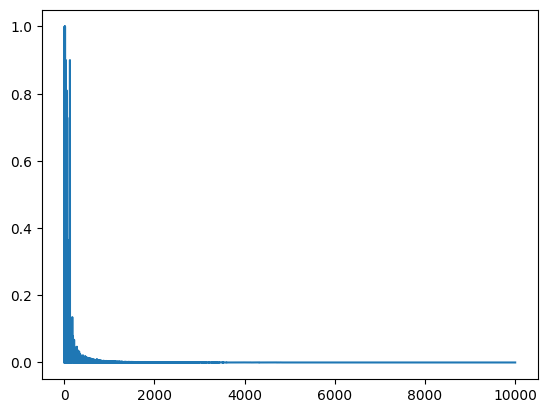

In [16]:
plt.plot(deltas)
plt.show()

In [17]:
print("final policy:")
print_policy(policy, grid)

final policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  R  |  R  |  U  |  L  |


In [18]:
# find V
V = {}
for s, Qs in Q.items():
    V[s] = max_dict(Q[s])[1]

print("final values:")
print_values(V, grid)

final values:
---------------------------
 0.81| 0.90| 1.00| 0.00|
---------------------------
 0.73| 0.00| 0.90| 0.00|
---------------------------
 0.65| 0.73| 0.81| 0.73|


# MC no Exploring Starts - Epsilon Greedy

In [19]:
def epsilon_greedy(policy, s, eps=0.1):
  p = np.random.random()
  if p < (1 - eps):
    return policy[s]
  else:
    return np.random.choice(ALL_POSSIBLE_ACTIONS)

In [20]:
def play_game(grid, policy, max_steps=20):

  # start state
  s = grid.reset()

  # choose action
  a = epsilon_greedy(policy, s)

  states = [s]
  actions = [a]
  rewards = [0]

  for _ in range(max_steps):
    r = grid.move(a)
    s = grid.current_state()

    rewards.append(r)
    states.append(s)
    
    if grid.game_over():
      break
    else:
      a = epsilon_greedy(policy, s)
      actions.append(a)

  # we want to return:
  # states  = [s(0), s(1), ..., s(T-1), s(T)]
  # actions = [a(0), a(1), ..., a(T-1),     ]
  # rewards = [   0, R(1), ..., R(T-1), R(T)]

  return states, actions, rewards

In [21]:
# use the standard grid again (0 for every step) so that we can compare
# to iterative policy evaluation
grid = standard_grid()
# try the negative grid too, to see if agent will learn to go past the "bad spot"
# in order to minimize number of steps
# grid = negative_grid(step_cost=-0.1)

# print rewards
print("rewards:")
print_values(grid.rewards, grid)

rewards:
---------------------------
 0.00| 0.00| 0.00| 1.00|
---------------------------
 0.00| 0.00| 0.00|-1.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|


In [22]:
# state -> action
# initialize a random policy
policy = {}
for s in grid.actions.keys():
    policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)

In [23]:
# initialize Q(s,a) and returns
Q = {}
sample_counts = {}
state_sample_count = {}
states = grid.all_states()
for s in states:
    if s in grid.actions: # not a terminal state
        Q[s] = {}
        sample_counts[s] = {}
        state_sample_count[s] = 0
        for a in ALL_POSSIBLE_ACTIONS:
            Q[s][a] = 0
            sample_counts[s][a] = 0
    else:
      # terminal state or state we can't otherwise get to
      pass

In [25]:
# repeat until convergence
deltas = []
for it in range(10000):
    if it % 1000 == 0:
        print(it)

    # generate an episode using pi
    biggest_change = 0
    states, actions, rewards = play_game(grid, policy)

    # create a list of only state-action pairs for lookup
    states_actions = list(zip(states, actions))

    T = len(states)
    G = 0
    for t in range(T - 2, -1, -1):
        # retrieve current s, a, r tuple
        s = states[t]
        a = actions[t]

        # update G
        G = rewards[t+1] + GAMMA * G

        # check if we have already seen (s, a) ("first-visit")
        if (s, a) not in states_actions[:t]:
            old_q = Q[s][a]
            sample_counts[s][a] += 1
            lr = 1 / sample_counts[s][a]
            Q[s][a] = old_q + lr * (G - old_q)

        # update policy
        policy[s] = max_dict(Q[s])[0]

        # update state sample count
        state_sample_count[s] += 1

        # update delta
        biggest_change = max(biggest_change, np.abs(old_q - Q[s][a]))
    deltas.append(biggest_change)


0
1000
2000
3000
4000
5000
6000
7000
8000
9000


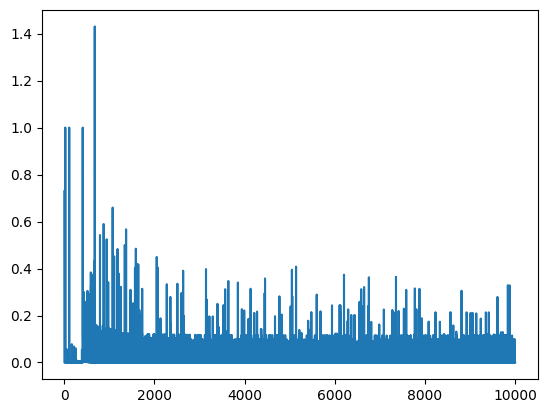

In [26]:
plt.plot(deltas)
plt.show()

In [27]:
print("final policy:")
print_policy(policy, grid)

final policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  L  |  U  |  R  |


In [28]:
# find V
V = {}
for s, Qs in Q.items():
    V[s] = max_dict(Q[s])[1]

print("final values:")
print_values(V, grid)

final values:
---------------------------
 0.79| 0.88| 1.00| 0.00|
---------------------------
 0.70| 0.00| 0.87| 0.00|
---------------------------
 0.61| 0.44| 0.67| 0.00|


In [33]:


print("state_sample_count:")
state_sample_count_arr = np.zeros((grid.rows, grid.cols))
for i in range(grid.rows):
    for j in range(grid.cols):
        if (i, j) in state_sample_count:
            state_sample_count_arr[i,j] = state_sample_count[(i, j)]
df = pd.DataFrame(state_sample_count_arr)
print(df)

state_sample_count:
         0        1        2     3
0  11007.0  10802.0  10441.0   0.0
1  11745.0      0.0    319.0   0.0
2  16358.0   1013.0    118.0  44.0
